In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [5]:
n_c = 90
hidden_size = 8
file = f'./dataset_reduced_{n_c}.json'

### Data


In [6]:
df = pd.read_json(file)
df.head(1)

,input,output,operation,kernel,input_reduced,output_reduced
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 1, 1, 1, 1]","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, ...","[[1.1171993303, 0.4665677453, -1.6899903152, 0...","[[1.8659102346, 0.1586968489, -1.5792994701, -..."


In [7]:
# 80% train, 20% test
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [8]:
# dataloaders
class IPARC(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'img_in': torch.tensor(row['input_reduced']).reshape(-1),
            'img_out': torch.tensor(row['output_reduced']).reshape(-1),
            'operation': torch.tensor(row['operation']).reshape(1, -1),
            'kernel': torch.tensor(row['kernel']),
        }
        
    @staticmethod
    def collate(batch):
        return {
            'img_in': torch.stack([x['img_in'] for x in batch]),
            'img_out': torch.stack([x['img_out'] for x in batch]),
            'operation': torch.stack([x['operation'] for x in batch]),
            'kernel': torch.stack([x['kernel'] for x in batch]),
        }
        
train_dataset = IPARC(train_df)
test_dataset = IPARC(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Model


In [9]:
class Model(nn.Module):
    def __init__(self, n_c, hdsz):
        super(Model, self).__init__()
        self.op_linreg = nn.Linear(4*(n_c + n_c)+hdsz, 1)
        self.kernel_linreg = nn.Linear(4*(n_c + n_c)+hdsz, 8)
        self.hidden_encoder = nn.Linear(hdsz+1+8, hdsz)

    def forward(self, img_in, img_out, op_prev, kernel_prev, hidden):
        hidden = torch.tanh(self.hidden_encoder(torch.cat([hidden, op_prev, kernel_prev], dim=-1)))
    
        cat = torch.cat([img_in, img_out, hidden], dim=-1)    
        op_logit = self.op_linreg(cat)
        kernel_logit = self.kernel_linreg(cat)
        
        return op_logit, kernel_logit, hidden

### Training


In [10]:
# trainig loop
def train(model, train_loader, test_loader, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    losses = {
        'train': [],
        'test': []
    }
    
    for epoch in range(epochs):
        model.train()
        loss_tot = 0
        for batch in train_loader:
            bs = batch['img_in'].shape[0]
            
            img_in = batch['img_in']
            img_out = batch['img_out']
            op = batch['operation']
            kernel = batch['kernel']
            
            hidden = torch.zeros(bs, hidden_size)
            loss = 0
            for i in range(len(op) - 1):
                op_logit, kernel_logit, hidden = model(img_in, img_out, op[:, :, i], kernel[:, i], hidden)
                op_loss = criterion(op_logit, op[:, :, i+1].float())
                kernel_loss = criterion(kernel_logit, kernel[:, i+1].float())
                loss += op_loss + kernel_loss
            loss /= len(op)
            loss_tot += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses['train'].append(loss_tot/len(train_loader))
        
        model.eval()
        loss_tot = 0
        with torch.no_grad():
            for batch in test_loader:
                bs = batch['img_in'].shape[0]

                img_in = batch['img_in']
                img_out = batch['img_out']
                op = batch['operation']
                kernel = batch['kernel']

                hidden = torch.zeros(bs, hidden_size)
                loss = 0
                for i in range(len(op) - 1):
                    op_logit, kernel_logit, hidden = model(img_in, img_out, op[:, :, i], kernel[:, i], hidden)
                    op_loss = criterion(op_logit, op[:, :, i+1].float())
                    kernel_loss = criterion(kernel_logit, kernel[:, i+1].float())
                    loss += op_loss + kernel_loss
                loss /= len(op)
                loss_tot += loss.item()
        losses['test'].append(loss_tot/len(test_loader))
            
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {losses["train"][-1]:.4f}, Test Loss: {losses["test"][-1]:.4f}')
        
    return losses

Epoch 1/50, Train Loss: 1.8641, Test Loss: 1.6571
Epoch 2/50, Train Loss: 1.2626, Test Loss: 1.7116
Epoch 3/50, Train Loss: 1.0999, Test Loss: 1.7175
Epoch 4/50, Train Loss: 0.9759, Test Loss: 1.6906
Epoch 5/50, Train Loss: 0.8337, Test Loss: 1.7582
Epoch 6/50, Train Loss: 0.7464, Test Loss: 1.7847
Epoch 7/50, Train Loss: 0.6706, Test Loss: 1.8014
Epoch 8/50, Train Loss: 0.6324, Test Loss: 1.8732
Epoch 9/50, Train Loss: 0.5992, Test Loss: 1.9168
Epoch 10/50, Train Loss: 0.5897, Test Loss: 1.9759
Epoch 11/50, Train Loss: 0.5787, Test Loss: 2.0131
Epoch 12/50, Train Loss: 0.5538, Test Loss: 2.0495
Epoch 13/50, Train Loss: 0.5730, Test Loss: 2.1051
Epoch 14/50, Train Loss: 0.5275, Test Loss: 2.1242
Epoch 15/50, Train Loss: 0.5485, Test Loss: 2.1757
Epoch 16/50, Train Loss: 0.5301, Test Loss: 2.2190
Epoch 17/50, Train Loss: 0.5503, Test Loss: 2.2480
Epoch 18/50, Train Loss: 0.5183, Test Loss: 2.2472
Epoch 19/50, Train Loss: 0.4990, Test Loss: 2.3210
Epoch 20/50, Train Loss: 0.4737, Test Lo

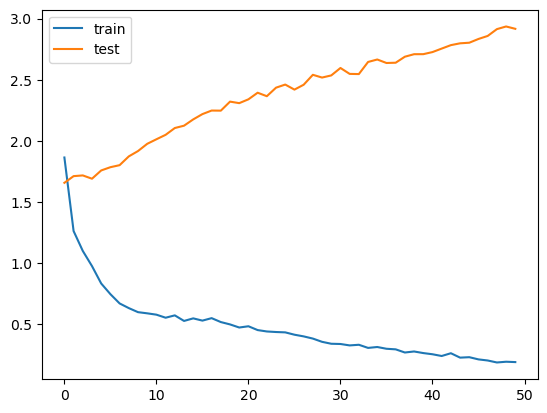

In [11]:
model = Model(n_c, hidden_size)
losses = train(model, train_loader, test_loader, epochs=50, lr=0.01)

plt.plot(losses['train'])
plt.plot(losses['test'])
plt.legend(['train', 'test'])
plt.show()